[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

---
# Setup Data

## Load & Display Data
[Kaggle Dataset](https://www.kaggle.com/ntnu-testimon/paysim1 "Synthetic Financial Datasets For Fraud Detection")

In [2]:
df = pd.read_csv('data/card.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Check Value Type

In [3]:
print("data types\n{}".format(df.info()))
print("\nnull values:\n{}".format(df.isnull().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
data types
None

null values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## Define Each Feature

### We have 11 initial features:

* **step:** Maps a unit of time in the real world. In this case 1 step is 1 hour of time, 743 is the end of the month
* **type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
* **amount:** amount of the transaction in local currency _(may be bigger then the account balance)_
* **nameOrig:** customer who started the transaction _(start with C for customer)_
* **oldbalanceOrg:** initial balance before the transaction _(at least 0)_
* **newbalanceOrig:** customer's balance after the transaction. _(at least 0)_
* **nameDest:** recipient ID of the transaction. _(start with C for customer)_
* **oldbalanceDest:** initial recipient balance before the transaction. _(at least 0)_
* **newbalanceDest:** recipient's balance after the transaction. _(at least 0)_
* **isFraud:** identifies a fraudulent transaction (1) and non fraudulent (0)
* **isFlaggedFraud:** flags illegal attempts to transfer more than 200.000 in a single transaction.

---
# Data Trends

### Transaction Types

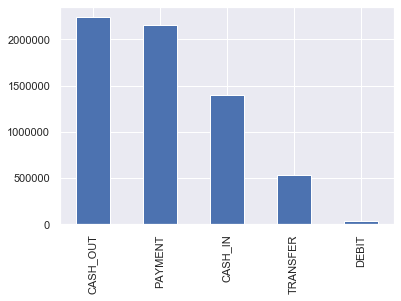

In [4]:
df['type'].value_counts().plot.bar()
plt.show()

In [5]:
precent = df['type'].value_counts(normalize=True)['DEBIT']*100
lines = df[df['type'] == 'DEBIT']['type'].value_counts()['DEBIT']
print("The precent of DEBIT in the Data Set is {:.2f}% ({} lines)".format(precent, lines))

The precent of DEBIT in the Data Set is 0.65% (41432 lines)


### Fraud happens aroud 0.13%

In [6]:
"{:.2f}%".format(df['isFraud'].value_counts(normalize=True)[1]*100)

'0.13%'

### Fraud is only in: TRANSFER, CASH OUT
#### (at about the same amount)

In [7]:
fraud = df[df['isFraud'] == 1]
fraud['type'].value_counts(normalize=True)*100

CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64

### Precentage of Transfer Fraud is about 0.77%

In [8]:
df[df['type'] == 'TRANSFER']['isFraud'].value_counts(normalize=True)[1]*100

0.7687991758442811

### Precentage of Cash Out Fraud is about 0.18%

In [9]:
df[df['type'] == 'CASH_OUT']['isFraud'].value_counts(normalize=True)[1]*100

0.18395530726256984

### If The Transaction Amount Was The Same As The Balance: Its Fraud

In [10]:
df[df['amount'] == df['oldbalanceOrg']]['isFraud'].unique()

array([1], dtype=int64)

### If the Existing Fraud Detection Flags the Transaction as Fraud, It's Fraud

In [11]:
df[df['isFlaggedFraud'] == 1]['isFraud'].unique()

array([1], dtype=int64)

### Clients who Commited Fraud also Have Legit Transactions

In [12]:
fraudClients = df[df['isFraud']==1]['nameDest'].unique()
df[df['nameDest']==fraudClients[0]].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
6167,6,TRANSFER,109985.65,C570434649,41851.00,0.00,C553264065,0.00,109985.65,0,0
7903,7,CASH_IN,10256.20,C111105514,3766080.24,3776336.45,C553264065,109985.65,99729.44,0,0
16381,8,CASH_OUT,111622.39,C1457214570,2347.00,0.00,C553264065,99729.44,5254.44,0,0
20003,8,CASH_IN,206097.39,C161724858,1991.12,208088.52,C553264065,211351.84,5254.44,0,0


### Though in general there are more Initiates then Recipients, In Fraudulent Transactions it's the other way

In [13]:
print("In Total:")
print("The Number Of Initiates is: {}".format(len(df['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df['nameDest'].unique())))
print("In Fraudulent Transactions:")
print("The Number Of Initiates is: {}".format(len(df[df['isFraud']==1]['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df[df['isFraud']==1]['nameDest'].unique())))

In Total:
The Number Of Initiates is: 6353307
The Number Of Recipients is: 2722362
In Fraudulent Transactions:
The Number Of Initiates is: 8213
The Number Of Recipients is: 8169


### Almost all of the fraudulent transactions where when the amount in the transaction was the same as the account balance

In [14]:
dfFraud = df[df['isFraud']==1][['amount', 'oldbalanceOrg']]
precent = dfFraud[dfFraud['amount']!=dfFraud['oldbalanceOrg']].shape[0]/dfFraud.shape[0]*100
print("The precentage of fraudulent transaction that didn't take the hull balace of the customer is {}%".format(precent))

The precentage of fraudulent transaction that didn't take the hull balace of the customer is 2.1794715694630464%


### The destination account doesn't seem to update according to the transferred amount, probebly to simulate the bank verifying the transaction

In [15]:
amount = df.loc[10]['amount']
delta = df.loc[10]['newbalanceDest'] - df.loc[10]['oldbalanceDest']
print('the amount transferred ({}) doesn\'t match the change in the destination account ({})'.format(amount, delta))

the amount transferred (9644.94) doesn't match the change in the destination account (147137.12)


---
# Predict Fraud

In [16]:
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [17]:
# Existing fraud doesnt always work
df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud'].value_counts()

0    8024
1      10
Name: isFlaggedFraud, dtype: int64

In [18]:
df['myFraud'] = df['isFlaggedFraud']
size = len(df[df['amount']==df['oldbalanceOrg']]['myFraud'])
d1 = df[df['amount']==df['oldbalanceOrg']]['myFraud']
d2 = df[df['amount']!=df['oldbalanceOrg']]['myFraud']
d1 = d1.replace(0, 1)
df['myFraud'] = pd.concat([d1, d2])

In [19]:
df[df['amount']==df['oldbalanceOrg']]['myFraud'].value_counts()

1    8034
Name: myFraud, dtype: int64

## Clear data from unneeded values for the model

### remove transactions types with no fraud
otherwise the models will take to long

#### note that dummy classifiers makes models slow
```
tmp = pd.get_dummies(data['type'])
data = data.join(tmp)
data = data.drop('type', axis=1)
data.head()
```

In [20]:
d1 = df[df['type']=='TRANSFER']
d2 = df[df['type']=='CASH_OUT']
d1['type'] = 1
d2['type'] = 0
df = pd.concat([d1, d2])
df.head()

C:\Users\idoya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\idoya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,myFraud
2,1,1,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,1
19,1,1,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,0
24,1,1,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,0
58,1,1,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0,0
78,1,1,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0,0


### check if step helps in finding if fraud exists

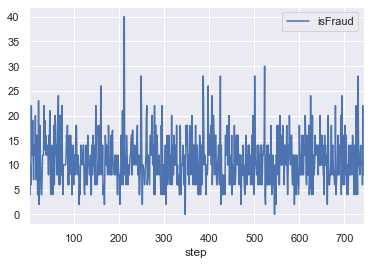

In [21]:
tmp = df[['step', 'isFraud']]
tmp.groupby(['step']).sum().plot()

change step to times of day 0-23

C:\Users\idoya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


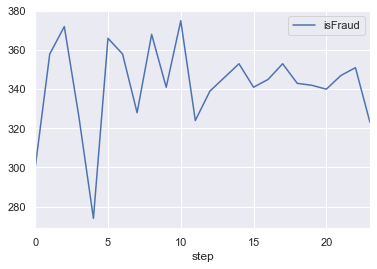

In [22]:
tmp = df[['step', 'isFraud']]
tmp['step'] = tmp['step']%24
tmp.groupby(['step']).sum().plot()

step doesn't realy help us

### Remove the unneeded columns

In [23]:
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud', 'step'], axis=1)
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,myFraud
2,1,181.00,181.00,0.0,0.00,0.00,1,1
19,1,215310.30,705.00,0.0,22425.00,0.00,0,0
24,1,311685.89,10835.00,0.0,6267.00,2719172.89,0,0
58,1,62610.80,79114.00,16503.2,517.00,8383.29,0,0
78,1,42712.39,10363.39,0.0,57901.66,24044.18,0,0


In [24]:
def normalize(x):
    df[x] = df[x]/df[x].max()
    
[normalize(x) for x in df]
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,myFraud
2,1.0,0.000002,0.000003,0.000000,0.000000,0.000000,1.0,1.0
19,1.0,0.002329,0.000012,0.000000,0.000063,0.000000,0.0,0.0
24,1.0,0.003372,0.000182,0.000000,0.000018,0.007634,0.0,0.0
58,1.0,0.000677,0.001328,0.000333,0.000001,0.000024,0.0,0.0
78,1.0,0.000462,0.000174,0.000000,0.000163,0.000068,0.0,0.0


In [25]:
X=df.drop('isFraud', axis=1)
y=df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train

In [26]:
def evaluate(test, prediction):
    print(classification_report(y_test,predictions))
    print(confusion_matrix(test, prediction))
    print(metrics.accuracy_score(test, prediction))

### Decision Tree

In [27]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

[[552402      2]
 [     8   1670]]
0.9999819521298292


### Logistic Regression

In [28]:
lr=LogisticRegression(random_state=0, solver='lbfgs', max_iter=200)
lr.fit(X_train,y_train)
predictions=lr.predict(X_test)
evaluate(y_test, predictions)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      0.98      0.99      1678

    accuracy                           1.00    554082
   macro avg       1.00      0.99      0.99    554082
weighted avg       1.00      1.00      1.00    554082

[[552403      1]
 [    38   1640]]
0.9999296133063337


### RandomForestClassifier

In [29]:
clf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

[[552404      0]
 [     8   1670]]
0.9999855617038633


In [30]:
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=10)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      0.98      0.99      1678

    accuracy                           1.00    554082
   macro avg       1.00      0.99      1.00    554082
weighted avg       1.00      1.00      1.00    554082

[[552403      1]
 [    31   1647]]
0.9999422468154533


In [31]:
clf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=10)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

[[552404      0]
 [     8   1670]]
0.9999855617038633


### Linear SVC

In [32]:
clf = LinearSVC(random_state=0, tol=1e30)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

[[552401      3]
 [     8   1670]]
0.999980147342812


In [33]:
clf = LinearSVC(random_state=0, tol=1e-2)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

[[552403      1]
 [     8   1670]]
0.9999837569168463


In [34]:
clf = LinearSVC(random_state=0, tol=1e-3)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
evaluate(y_test, predictions)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

[[552403      1]
 [     8   1670]]
0.9999837569168463
